In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [3]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')


In [4]:
from openai import Agent, AgentPool, train_model_on_agent

In [5]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [6]:


def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.xticks()
    plt.axis('off')
    
    
    def update_scene(num, frames, patch):
        patch.set_data(frames[num])
        return patch,

    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [7]:
an=Agent(min_distance=-float('inf'),max_distance=float('inf'),
         min_angle=-np.pi/2,max_angle=np.pi/2,seed=42)

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

model_untrained = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(2, activation="softmax"),
])


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


(0.0, 200.0)

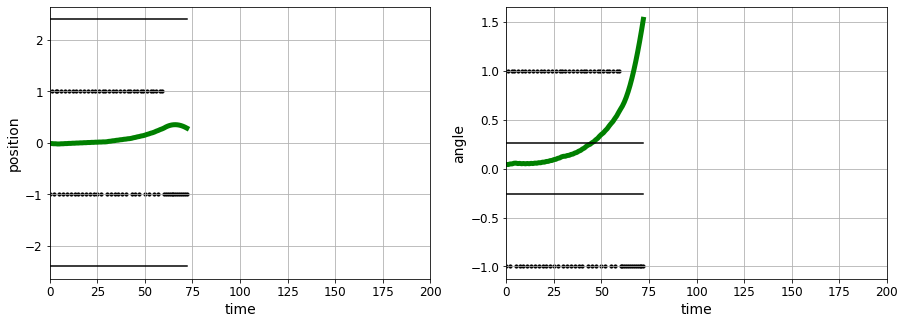

In [65]:
obs,choices,frames=an.play_a_round(model_untrained)
_,axs=plt.subplots(1,2, figsize=(15,5))
axs[0].plot(obs[:,0],lw=5,color='g')
#axs[0].plot(obs[:,1])
axs[0].plot(np.ones_like(obs[:,1])*2.4, color='k')
axs[0].plot(-np.ones_like(obs[:,1])*2.4, color='k')
axs[0].scatter(range(len(obs)),2*choices-1,s=10,color='k')
axs[0].grid(True)
axs[0].set_xlabel('time')
axs[0].set_ylabel('position')
axs[0].set_xlim(0,200)
axs[1].plot(obs[:,2],lw=5,color='g')
#axs[1].plot(obs[:,3])
axs[1].plot(np.ones_like(obs[:,1])*15./180*np.pi, color='k')
axs[1].plot(-np.ones_like(obs[:,1])*15./180*np.pi, color='k')
axs[1].scatter(range(len(obs)),2*choices-1,s=10, color='k')
axs[1].grid(True)
axs[1].set_xlabel('time')
axs[1].set_ylabel('angle')
axs[1].set_xlim(0,200)

In [66]:
plot_animation(frames)

In [11]:
optimizer = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.sparse_categorical_crossentropy

In [12]:
n_iterations=150

In [13]:
n_agents=10


In [51]:
np.random.seed(42)
tf.random.set_seed(42)

model1 = keras.models.Sequential([
    keras.layers.Dense(5, activation="relu", input_shape=[4]),
    keras.layers.Dense(2, activation="softmax"),
])



In [20]:

for a,d in ((10,2),(5,1),(3,.5)):
    print('Training with max distance {distance} and angular deviation {angle} degress\n'.format(angle=a, distance=d))
    ap1=AgentPool(n_agents,min_angle=-a*np.pi/180.,max_angle=a*np.pi/180.,min_distance=-d,max_distance=d)
    train_model_on_agent(ap1,model1,optimizer,loss_fn,n_iterations)

Training with max distance 2 and angular deviation 10 degress

Iteration: 149, mean rewards: 195.4Training with max distance 1 and angular deviation 5 degress

Iteration: 149, mean rewards: 197.9Training with max distance 0.5 and angular deviation 3 degress

Iteration: 149, mean rewards: 155.5

In [52]:
#model1.save_weights('models/max_distance_1')
model1.load_weights('models/max_distance_1')

(-0.5, 0.5)

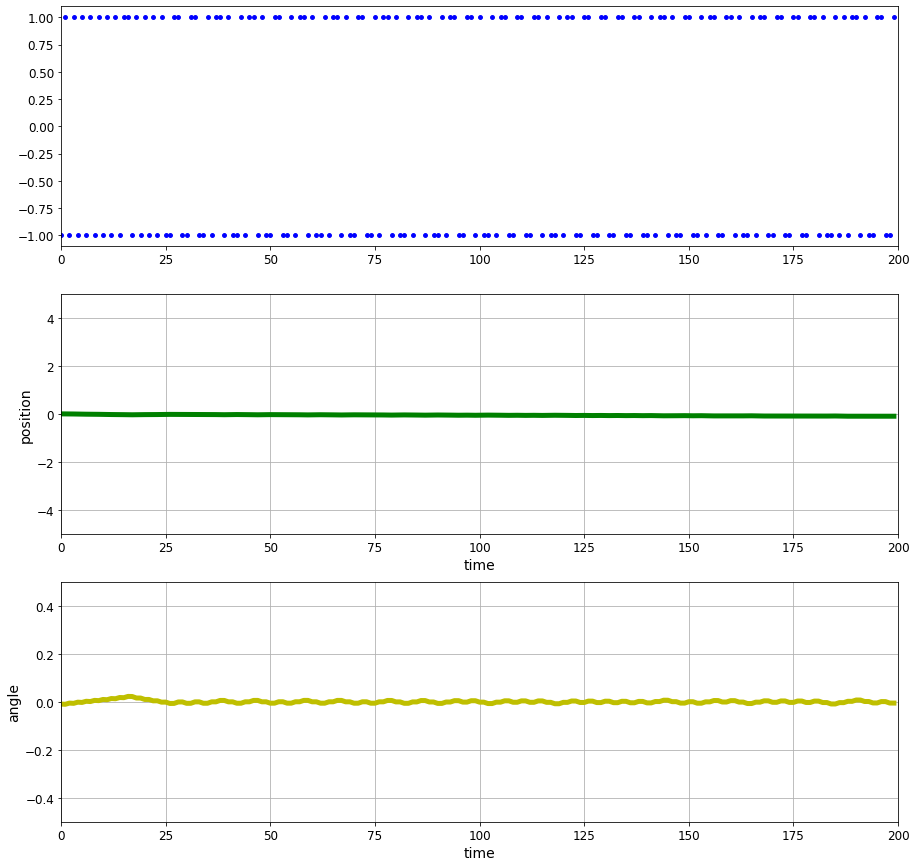

In [94]:
obs,choices,frames=an.play_a_round(model1)
_,axs=plt.subplots(3,1, figsize=(15,15))
axs[0].scatter(range(len(obs)),2*choices-1,s=15,color='b')
axs[0].set_xlim(0,200)

axs[1].plot(obs[:,0],lw=5,color='g')
#axs[0].plot(obs[:,1])
#axs[0].plot(np.ones_like(obs[:,1])*2.4, color='k')
#axs[0].plot(-np.ones_like(obs[:,1])*2.4, color='k')
#axs[1].scatter(range(len(obs)),2*choices-1,s=15,color='b')
axs[1].grid(True)
axs[1].set_xlabel('time')
axs[1].set_ylabel('position')
axs[1].set_xlim(0,200)
axs[1].set_ylim(-5,5)
axs[2].plot(obs[:,2],lw=5,color='y')
#axs[1].plot(obs[:,3])
#axs[1].plot(np.ones_like(obs[:,1])*15./180*np.pi, color='k')
#axs[1].plot(-np.ones_like(obs[:,1])*15./180*np.pi, color='k')
#axs[2].scatter(range(len(obs)),2*choices-1,s=10, color='b')
axs[2].grid(True)
axs[2].set_xlabel('time')
axs[2].set_ylabel('angle')
axs[2].set_xlim(0,200)
axs[2].set_ylim(-.5,.5)

In [95]:
plot_animation(frames)

In [169]:
an.env.env.

<TimeLimit<CartPoleEnv<CartPole-v1>>>

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model2 = keras.models.Sequential([
    keras.layers.Dense(5, activation="relu", input_shape=[4]),
    keras.layers.Dense(2, activation="softmax"),
])

In [19]:
-1*np.pi/180,30*np.pi/180

(-0.017453292519943295, 0.5235987755982988)

In [20]:
optimizer = keras.optimizers.Adam()

In [25]:
for min_angle in (-.06,):
    ap2=AgentPool(n_agents,min_angle=min_angle,max_angle=30*np.pi/180,max_distance=float('inf'))
    train_model_on_agent(ap2,model2,optimizer,loss_fn,n_iterations)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Iteration: 94, mean rewards: 185.9

KeyboardInterrupt: 

In [22]:
4

4

In [13]:
model2.load_weights('models/max_distance_inf')

In [22]:
from sklearn.linear_model import LinearRegression

In [91]:
an=Agent(min_distance=-float('inf'),max_distance=float('inf'),
         min_angle=-np.pi/2,max_angle=np.pi/2)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


(-0.5, 0.5)

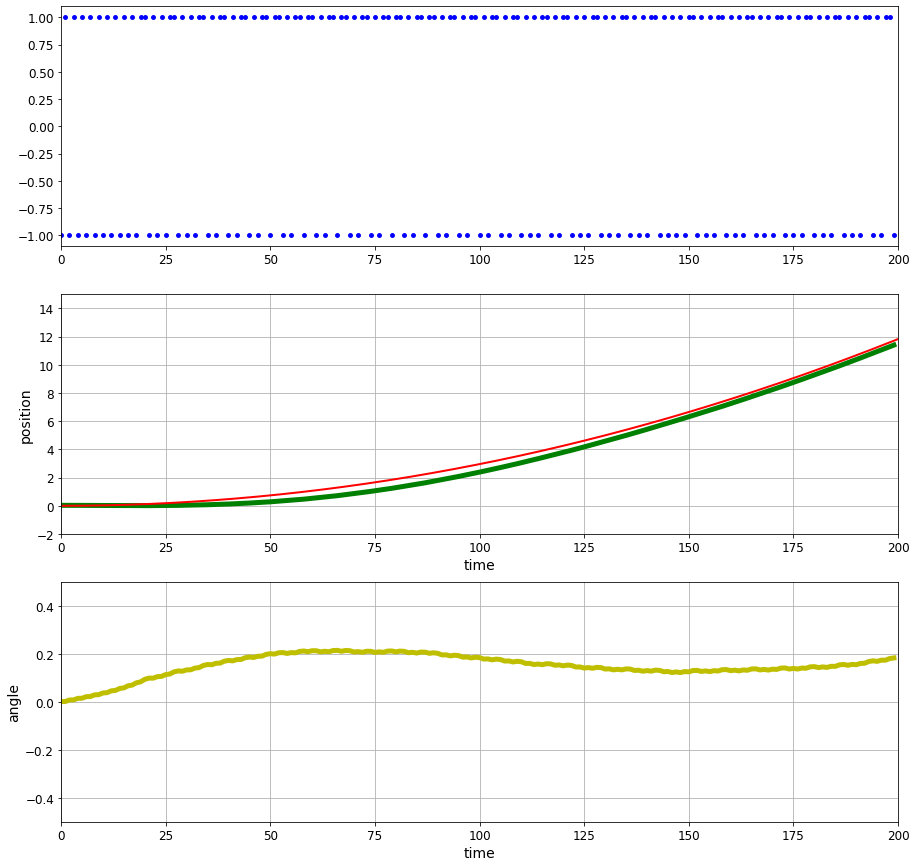

In [92]:
obs,choices,frames=an.play_a_round(model2)
_,axs=plt.subplots(3,1, figsize=(15,15))
axs[0].scatter(range(len(obs)),2*choices-1,s=15,color='b')
axs[0].set_xlim(0,200)

axs[1].plot(obs[:,0],lw=5,color='g')
#axs[0].plot(obs[:,1])
#axs[0].plot(np.ones_like(obs[:,1])*2.4, color='k')
#axs[0].plot(-np.ones_like(obs[:,1])*2.4, color='k')
#axs[1].scatter(range(len(obs)),2*choices-1,s=15,color='b')
axs[1].grid(True)
axs[1].set_xlabel('time')
axs[1].set_ylabel('position')
axs[1].set_xlim(0,200)
axs[1].set_ylim(-2,15)

lr=LinearRegression()
lr.fit(0.5*np.arange(200).reshape(-1,1)**2,obs[:,0])
t=np.linspace(0,200,1000)
y=lr.coef_*.5*t**2
axs[1].plot(t,y,lw=2,color='r')

axs[2].plot(obs[:,2],lw=5,color='y')
#axs[1].plot(obs[:,3])
#axs[1].plot(np.ones_like(obs[:,1])*15./180*np.pi, color='k')
#axs[1].plot(-np.ones_like(obs[:,1])*15./180*np.pi, color='k')
#axs[2].scatter(range(len(obs)),2*choices-1,s=10, color='b')
axs[2].grid(True)
axs[2].set_xlabel('time')
axs[2].set_ylabel('angle')
axs[2].set_xlim(0,200)
axs[2].set_ylim(-.5,.5)

In [93]:
plot_animation(frames)

In [149]:
lr=LinearRegression()
lr.fit(0.5*np.arange(200).reshape(-1,1)**2,obs[:,0])
t=np.linspace(0,200,1000)
y=lr.coef_*.5*t**2

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [151]:
lr.coef_

array([0.00065478])

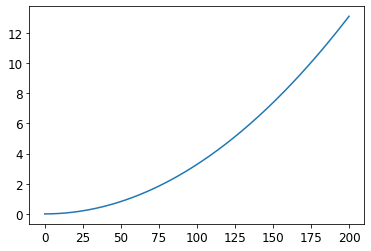

In [152]:
t=np.linspace(0,200,1000)
y=lr.coef_*.5*t**2
plt.plot(t,y)

In [35]:
lr.intercept_

0.02811028911696345

In [120]:
class MyModel(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.count=tf.Variable(0,dtype=tf.int8)
        
    def call(self,x):
        if tf.random.uniform(shape=(1,))>.5:
            r= tf.constant([[0,1]])
        else:
            r = tf.constant([[1,0]])
            
        self.count.assign_add(1)
        return r

In [121]:
tf.random.uniform(shape=(1,))>.6

<tf.Tensor: shape=(1,), dtype=bool, numpy=array([False])>

In [122]:
model3=MyModel()

In [123]:
model3(tf.constant([[1,2,3,4]]))

<tf.Tensor: shape=(1, 2), dtype=int32, numpy=array([[0, 1]], dtype=int32)>

In [124]:
model3.count

<tf.Variable 'Variable:0' shape=() dtype=int8, numpy=1>

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


(0.0, 200.0)

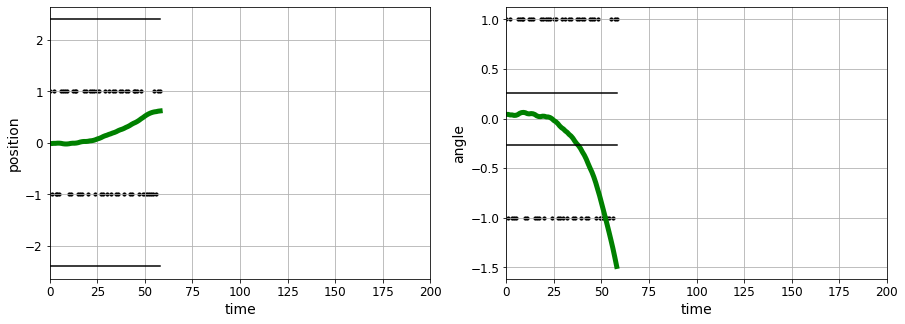

In [125]:
obs,choices,frames=an.play_a_round(model3)
_,axs=plt.subplots(1,2, figsize=(15,5))
axs[0].plot(obs[:,0],lw=5,color='g')
#axs[0].plot(obs[:,1])
axs[0].plot(np.ones_like(obs[:,1])*2.4, color='k')
axs[0].plot(-np.ones_like(obs[:,1])*2.4, color='k')
axs[0].scatter(range(len(obs)),2*choices-1,s=10,color='k')
axs[0].grid(True)
axs[0].set_xlabel('time')
axs[0].set_ylabel('position')
axs[0].set_xlim(0,200)
axs[1].plot(obs[:,2],lw=5,color='g')
#axs[1].plot(obs[:,3])
axs[1].plot(np.ones_like(obs[:,1])*15./180*np.pi, color='k')
axs[1].plot(-np.ones_like(obs[:,1])*15./180*np.pi, color='k')
axs[1].scatter(range(len(obs)),2*choices-1,s=10, color='k')
axs[1].grid(True)
axs[1].set_xlabel('time')
axs[1].set_ylabel('angle')
axs[1].set_xlim(0,200)

In [104]:
model3.count

<tf.Variable 'Variable:0' shape=() dtype=int8, numpy=25>

In [42]:
plot_animation(frames)

In [36]:
np.random.seed(42)
tf.random.set_seed(42)
 
model3 = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(5, activation="elu"),
    keras.layers.Dense(2, activation="softmax"),
])

In [37]:
ap3=AgentPool(n_agents)

In [38]:
train_model_on_agent(ap3,model3,optimizer,loss_fn,n_iterations)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Iteration: 149, mean rewards: 200.0

200


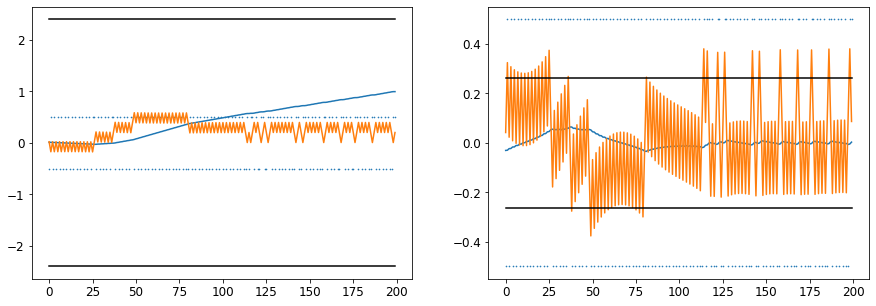

In [39]:
obs, frames=an.play_a_round(model3)
print(len(obs))
_,axs=plt.subplots(1,2, figsize=(15,5))
axs[0].plot(obs[:,0])
axs[0].plot(obs[:,1])
axs[0].plot(np.ones_like(obs[:,4])*2.4, color='k')
axs[0].plot(-np.ones_like(obs[:,4])*2.4, color='k')
axs[0].scatter(range(len(obs)),obs[:,4]-.5,s=.4)
axs[1].plot(obs[:,2])
axs[1].plot(obs[:,3])
axs[1].plot(np.ones_like(obs[:,4])*15./180*np.pi, color='k')
axs[1].plot(-np.ones_like(obs[:,4])*15./180*np.pi, color='k')
axs[1].scatter(range(len(obs)),obs[:,4]-.5,s=.4)

In [40]:
import gym
env=gym.make("CartPole-v1")

In [41]:
env.spec

EnvSpec(CartPole-v1)

In [42]:
env.reward_range

(-inf, inf)

In [43]:
env.metadata

{'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}

In [44]:
env.action_space

Discrete(2)

In [45]:
env.observation_space

Box(4,)

In [61]:
class House:

	def __init__(self, price):
		self._price = price

	@property
	def price(self):
		return self._price
	
	@price.setter
	def price(self, new_price):
		if new_price > 0 and isinstance(new_price, float):
			self._price = new_price
		else:
			print("Please enter a valid price")

	@price.deleter
	def price(self):
		del self._price

In [63]:
t=House(70)

In [64]:
t._price

70

In [65]:
t.price

70

In [67]:
t.price=7.9